<a href="https://colab.research.google.com/github/scoringwolf/Triton/blob/main/traj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git lfs install --skip-smudge
!git clone https://github.com/scoringwolf/Triton.git
!git lfs pull
!git lfs install --force

Git LFS initialized.
Cloning into 'Triton'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (4/4), 431.79 KiB | 5.20 MiB/s, done.
Not in a git repository.
Git LFS initialized.


In [2]:
!pip install rocketpy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

from rocketpy import Environment, Flight, Function, Rocket, SolidMotor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65860 sha256=2915717443111cde31cb3e014aeca9f47cda0e9de9c6ccb9e818ebdba27f9c44
  Stored in directory: /root/.cache/pip/wheels/16/7c/e6/621a95f24bd1ff987368f1c37881ffe013433ff6b413d87fcb
Successfully built simplekml


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [19]:
plt.style.use("seaborn-v0_8-dark-palette")

In [35]:
parameters = {
    # Mass Details
    "rocket_mass": (21.525, 0.010), # Rocket dry mass: 20.846 kg
    # propulsion details
    "motor_structure_mass": (8.064, 0.1),
    "burn_time": (3.9, 0.1),
    "nozzle_radius": (0.049, 0.001),
    "throat_radius": (0.049, 0.001),
    "grain_separation": (0.002, 0.001),
    "grain_density": (908.907, 30),
    "grain_outer_radius": (0.033, 0.001),
    "grain_initial_inner_radius": (0.015, 0.002),
    "grain_initial_height": (0.12, 0.001),
    "grains_center_of_mass_position": (-0.35, 0.100),
    "nozzle_position": (0, 0.100),
    "motor_position": (3.391, 0.100),
    # aerodynamic details
    "center_of_mass_without_motor": (1.3, 0.100),
    "drag_coefficient": (0.44, 0.1),
    "inertia_i": (73.316, 0.3 * 73.316),
    "inertia_z": (0.15982, 0.3 * 0.15982),
    "radius": (0.1015, 0.001),
    "power_off_drag": (1, 0.033),
    "power_on_drag": (1, 0.033),
    ## nose cone
    "nose_length": (0.5, 0.001),
    "nose_radius": (0.15, 0.001),
    "nose_position": (0, 0.100),
    ## fins
    "fin_span": (0.13, 0.001),
    "fin_root_chord": (0.30, 0.001),
    "fin_tip_chord": (0.11, 0.001),
    "fin_sweep_angle": (49.09, 0.5),
    "fin_position": (3.050, 0.100),
    ## transitions
    "radius": (0.15, 0.010),
    # launch and environment details
    "wind_direction": (0, 3),
    "wind_speed": (1, 0.30),
    "inclination": (90, 1),
    "heading": (181, 3),
    "rail_length": (5.2, 0.001),
    # parachute details
    "cd_s_drogue": (1.5 * np.pi * (24 * 25.4 / 1000) * (24 * 25.4 / 1000) / 4, 0.1),
    "cd_s_main": (2.2 * np.pi * (120 * 25.4 / 1000) * (120 * 25.4 / 1000) / 4, 0.1),
    "lag_rec": (1, 0.5),
}

# rocket: nose_to_tail

In [9]:
#!/usr/bin/env python
!pip install cdsapi
import cdsapi
c = cdsapi.Client()
c.retrieve('reanalysis-era5-complete', { # Requests follow MARS syntax
                                         # Keywords 'expver' and 'class' can be dropped. They are obsolete
                                         # since their values are imposed by 'reanalysis-era5-complete'
    'date'    : '2013-01-01',            # The hyphens can be omitted
    'levelist': '1/10/100/137',          # 1 is top level, 137 the lowest model level in ERA5. Use '/' to separate values.
    'levtype' : 'ml',
    'param'   : '130',                   # Full information at https://apps.ecmwf.int/codes/grib/param-db/
                                         # The native representation for temperature is spherical harmonics
    'stream'  : 'oper',                  # Denotes ERA5. Ensemble members are selected by 'enda'
    'time'    : '00/to/23/by/6',         # You can drop :00:00 and use MARS short-hand notation, instead of '00/06/12/18'
    'type'    : 'an',
    'area'    : '80/-50/-25/0',          # North, West, South, East. Default: global
    'grid'    : '1.0/1.0',               # Latitude/longitude. Default: spherical harmonics or reduced Gaussian grid
    'format'  : 'netcdf',                # Output needs to be regular lat-lon, so only works in combination with 'grid'!
}, 'Triton/ERA5.nc')     # Output file. Adapt as you wish.

  Preparing metadata (setup.py) ... done
  Created wheel for cdsapi: filename=cdsapi-0.6.1-py2.py3-none-any.whl size=12006 sha256=0087b2192fa8ae6b256ae510d8bf735f8c1d699b6552892d93a55e59df7c0d12
  Stored in directory: /root/.cache/pip/wheels/7c/63/08/45461d6f6636c1aba7846828d8c787a064073945048f76d44a
Successfully built cdsapi


2023-11-30 12:10:14,978 INFO Welcome to the CDS
INFO:cdsapi:Welcome to the CDS
2023-11-30 12:10:14,982 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-complete
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-complete
2023-11-30 12:10:15,228 INFO Request is completed
INFO:cdsapi:Request is completed
2023-11-30 12:10:15,232 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data5/adaptor.mars.external-1700535574.065834-19066-13-c3aae8cc-0283-45fd-8745-9e2afb426e13.nc to Triton/ERA5.nc (170.8K)
INFO:cdsapi:Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data5/adaptor.mars.external-1700535574.065834-19066-13-c3aae8cc-0283-45fd-8745-9e2afb426e13.nc to Triton/ERA5.nc (170.8K)
2023-11-30 12:10:16,440 INFO Download rate 141.9K/s
INFO:cdsapi:Download rate 141.9K/s


Result(content_length=174868,content_type=application/x-netcdf,location=https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data5/adaptor.mars.external-1700535574.065834-19066-13-c3aae8cc-0283-45fd-8745-9e2afb426e13.nc)

In [14]:
# Environment conditions
env = Environment(
    gravity=9.81,
    date=(2019, 8, 10, 21),
    latitude = -23.363611,
    longitude = -48.011389,
    elevation=668,
)

env.set_atmospheric_model(
    type="Ensemble",
    file="Triton/ERA5.nc",
    dictionary="ECMWF",
)


Gravity Details

Acceleration of gravity at surface level:    9.8100 m/s²
Acceleration of gravity at  11.628 km (ASL): 9.8100 m/s²


Launch Site Details

Launch Date: 2019-08-10 21:00:00 UTC
Launch Site Latitude: -23.36361°
Launch Site Longitude: -48.01139°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 192123.24 W    7413017.14 S
Launch Site UTM zone: 23K
Launch Site Surface Elevation: 668.0 m


Atmospheric Model Details

Atmospheric Model Type: Ensemble
Ensemble Maximum Height: 11.628 km
Ensemble Time Period: From  2019-08-10 12:00:00  to  2019-08-10 21:00:00  UTC
Ensemble Hour Interval: 3  hrs
Ensemble Latitude Range: From  -20.0 ° To  -26.0 °
Ensemble Longitude Range: From  -50.0 ° To  -45.0 °
Number of Ensemble Members: 10
Selected Ensemble Member: 0  (Starts from 0)


Surface Atmospheric Conditions

Surface Wind Speed: 3.27 m/s
Surface Wind Direction: 324.72°
Surface Wind Heading: 144.72°
Surface Pressure: 943.06 hPa
Surface Temperature: 300.76 K
Surface Air Density: 1

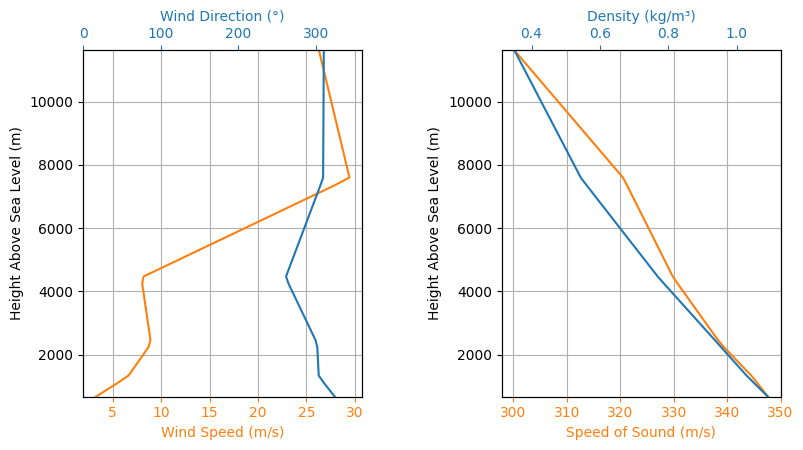

In [16]:
env.info()

In [21]:
motor_l1395 = SolidMotor(
    thrust_source="/content/Triton/thrustCurve.csv",
    burn_time=parameters.get("burn_time")[0],
    dry_mass=parameters.get("motor_structure_mass")[0],
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=parameters.get("grains_center_of_mass_position")[0],
    grains_center_of_mass_position=parameters.get("grains_center_of_mass_position")[0],
    grain_number=5,
    grain_separation=parameters.get("grain_separation")[0],
    grain_density=parameters.get("grain_density")[0],
    grain_outer_radius=parameters.get("grain_outer_radius")[0],
    grain_initial_inner_radius=parameters.get("grain_initial_inner_radius")[0],
    grain_initial_height=parameters.get("grain_initial_height")[0],
    nozzle_radius=parameters.get("nozzle_radius")[0],
    throat_radius=parameters.get("throat_radius")[0],
    interpolation_method="linear",
    nozzle_position=parameters.get("nozzle_position")[0],
    coordinate_system_orientation="combustion_chamber_to_nozzle" #combustion_chamber_to_nozzle"
)

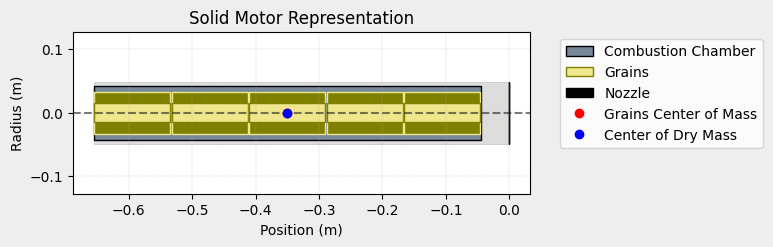

In [22]:
motor_l1395.plots.draw()

Nozzle Details
Nozzle Radius: 0.049 m
Nozzle Throat Radius: 0.049 m

Grain Details
Number of Grains: 5
Grain Spacing: 0.002 m
Grain Density: 908.907 kg/m3
Grain Outer Radius: 0.033 m
Grain Inner Radius: 0.015 m
Grain Height: 0.12 m
Grain Volume: 0.000 m3
Grain Mass: 0.296 kg

Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 1.480 kg
Average Propellant Exhaust Velocity: 6456.794 m/s
Average Thrust: 2450.680 N
Maximum Thrust: 2862.488292 N at 1.253318547 s after ignition.
Total Impulse: 9557.652 Ns



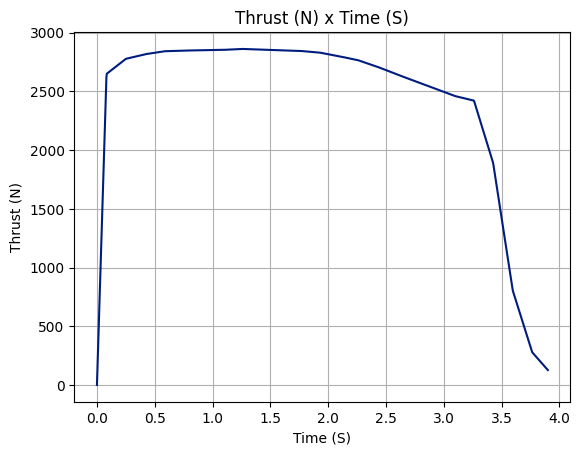

In [23]:
motor_l1395.info()

In [36]:
ndrt2020 = Rocket(
    radius=parameters.get("radius")[0],
    mass=parameters.get("rocket_mass")[0],
    inertia=(
        parameters.get("inertia_i")[0],
        parameters.get("inertia_i")[0],
        parameters.get("inertia_z")[0],
    ),
    power_off_drag=parameters.get("drag_coefficient")[0],
    power_on_drag=parameters.get("drag_coefficient")[0],
    center_of_mass_without_motor=parameters.get("center_of_mass_without_motor")[0],
    coordinate_system_orientation="nose_to_tail",
)
ndrt2020.set_rail_buttons(1.5, 2, 45)

ndrt2020.add_motor(
    motor=motor_l1395, position=parameters.get("motor_position")[0]
)

In [37]:
nose_cone = ndrt2020.add_nose(
    length=parameters.get("nose_length")[0],
    kind="tangent",
    position=parameters.get("nose_position")[0]
)
fin_set = ndrt2020.add_trapezoidal_fins(
    4,
    span=parameters.get("fin_span")[0],
    root_chord=parameters.get("fin_root_chord")[0],
    tip_chord=parameters.get("fin_tip_chord")[0],
    position=parameters.get("fin_position")[0],
    sweep_angle=parameters.get("fin_sweep_angle")[0],
    radius=parameters.get("radius")[0],
)


In [38]:
drogue = ndrt2020.add_parachute(
    "Drogue",
    cd_s=parameters.get("cd_s_drogue")[0],
    trigger="apogee",
    sampling_rate=105,
    lag=parameters.get("lag_rec")[0],
    noise=(0, 8.3, 0.5),
)
main = ndrt2020.add_parachute(
    "Main",
    cd_s=parameters.get("cd_s_main")[0],
    trigger=167.64,
    sampling_rate=105,
    lag=parameters.get("lag_rec")[0],
    noise=(0, 8.3, 0.5),
)

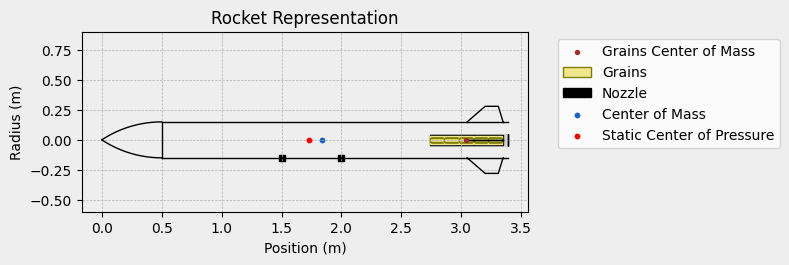

In [39]:
ndrt2020.draw()

In [40]:
ndrt2020.info()


Inertia Details

Rocket Mass: 21.525 kg (without motor)
Rocket Dry Mass: 29.589 kg (with unloaded motor)
Rocket Loaded Mass: 31.069 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 91.097 kg*m2
Rocket Inertia (with unloaded motor) 22: 91.097 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.160 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.15 m
Rocket Frontal Area: 0.070686 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.474 m
Rocket Center of Dry Mass - Nozzle Exit: 1.617 m
Rocket Center of Dry Mass - Center of Propellant Mass: 1.267 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.060 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 2.084/rad

Center of Pressure

Nose Cone Center of

In [41]:
# Flight
flight = Flight(
    rocket=ndrt2020,
    environment=env,
    rail_length=parameters.get("rail_length")[0],
    inclination=parameters.get("inclination")[0],
    heading=parameters.get("heading")[0],
)


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 668.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: -0.009 | e1: -0.000 | e2: -0.000 | e3: -1.000
Euler Angles - Spin φ : -90.50° | Nutation θ: -0.00° | Precession ψ: -90.50°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 2.19 m/s
Lateral Surface Wind Speed: 2.28 m/s


Launch Rail

Launch Rail Length: 5.2  m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 181.00°


Rail Departure State

Rail Departure Time: 0.338 s
Rail Departure Velocity: 22.814 m/s
Rail Departure Stability Margin: -0.340 c
Rail Departure Angle of Attack: 7.932°
Rail Departure Thrust-Weight Ratio: 9.223
Rail Departure Reynolds Number: 4.079e+05


Burn out State

Burn out time: 3.900 s
Altitude at burn out: 538.815 m (AGL)
Rocket velocity at burn out: 223.937 m/s
Freestream velocity at burn out: 223.485 m/s
Mach Number at burn out: 0.647
Kinetic energy at b

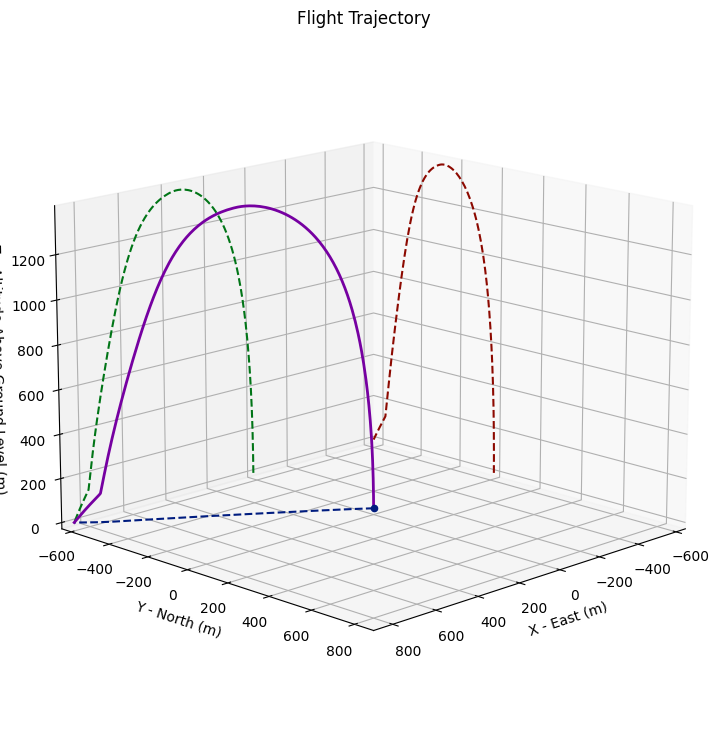

In [42]:
flight.info()
flight.plots.trajectory_3d()